<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/simple_interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple interface

coupled problem with two variables and an interface

linerized F form and stabilized F form

In [0]:
# This program shows how to implement interface boundary condition using PUFEM
# simple coupled problem

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-23
# Last changed: 2019-09-23

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

In [0]:
# install Fenics: 2 mins
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2019.1.0


Cloning into 'Practical_FEM_FEniCS_Colab'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 7), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (25/25), done.
Practical_FEM_FEniCS_Colab
##### Linearization #####
##### Stablization #####


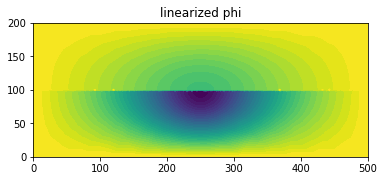

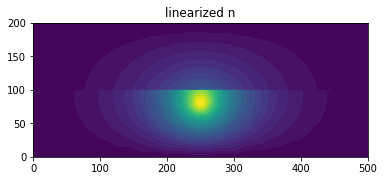

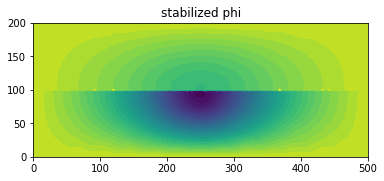

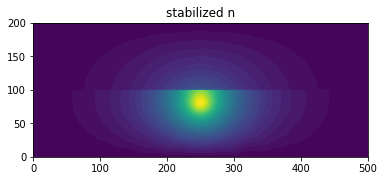

In [0]:
def read_h5(filename = 'file.h5'):
	'''Description: Convert mesh written in XML format into H5 format
	   Write mesh tags (boundaries, domains) into H5 file
	   Input:  XML mesh
	   Output: H5 mesh
	'''
	mesh = Mesh()
	hdf = HDF5File(mesh.mpi_comm(), filename, "r")
	hdf.read(mesh, "/mesh", False)
	dim = mesh.topology().dim()
	cell_markers = MeshFunction("size_t", mesh, dim)
	hdf.read(cell_markers, "/cell_markers")
	facet_markers = MeshFunction("size_t", mesh, dim-1)
	hdf.read(facet_markers, "/facet_markers")
	return mesh, cell_markers, facet_markers


# clone my repository
! git clone --recursive 'https://github.com/DuyDucNguyen/Practical_FEM_FEniCS_Colab/'
! ls


# load mesh
mesh_name = 'Practical_FEM_FEniCS_Colab/Geometry/2D_specimen_vacuum.h5'
mesh, cell_markers, facet_markers = read_h5(mesh_name)


parameters["ghost_mode"] = "shared_facet" # 'none', 'shared_facet', "shared_vertex"
#info(parameters, True)
#parameters["plotting_backend"] = "matplotlib"


# define subdomains and cell measure
dx = Measure("dx", domain = mesh, subdomain_data = cell_markers)


# define interface and facet measure
dS = Measure("dS", domain = mesh, subdomain_data = facet_markers)


#File("dS.pvd") << facet_domains
#File("domains.pvd") << cell_domains


x = SpatialCoordinate(mesh)

# indicator functions for the two subdomains
I0 = conditional(x[1] < 100.0, 1, 0)
I1 = conditional(x[1] > 100.0, 1, 0)

# material parameters
c0, c1 = Constant(1.0), Constant(1.0)
c = I0 * c0 + I1 * c1
k = Constant(8.0)

c00 = c0*I0


# define Gausian source term
Sn_str = '(I_0/(sigma_x*sigma_y))*exp( -(pow((x[0] - Bx)/sigma_x, 2.0) + pow((x[1] - By)/sigma_y, 2.0) ) )'
Sn = Expression( Sn_str, degree = 1, I_0 = 100.0,
    Bx = 250, By = 80, sigma_x = 10.0, sigma_y = 10.0)
f = Sn


# define function space
p = 1
V_ele = VectorElement("CG", mesh.ufl_cell(), p) # probably one needs to set dim=3?
f_ele = FiniteElement("CG", mesh.ufl_cell(), p)
WW = FunctionSpace(mesh, MixedElement([V_ele, V_ele]))

V = FunctionSpace(mesh, "CG", 1)
u_cg = project(c00, V)
#plot(u_cg)
#plt.show()




# define variational forms
dunks, tests = TrialFunction(WW), TestFunction(WW)
(dphi, dn) = split(dunks)
(tphi, tn) = split(tests)


# dirichlet boundary on the exterior
bc_phi = DirichletBC(WW.sub(0), (0., 0.), "on_boundary")
bc_n = DirichletBC(WW.sub(1), (0., 0.), "on_boundary")
bcs = [bc_phi, bc_n]


# phi
a_dphi = c0*inner(grad(dphi[0]), grad(tphi[0]))*dx(0) \
      + c1*inner(grad(dphi[1]), grad(tphi[1]))*dx(1)
L_dphi = (-dn[0])*tphi[0]*dx(0) + (-dn[1]) *tphi[1]*dx(1) \


# n
a_dn = c0*inner(grad(dn[0]), grad(tn[0]))*dx(0) \
    + c1*inner(grad(dn[1]), grad(tn[1]))*dx(1)
L_dn = f*tn[0]*dx(0) + f*tn[1]*dx(1) \


# interface boundary condition
jmp_dphi = avg(dphi[0]) - avg(dphi[1])
jmp_tphi = avg(tphi[0]) - avg(tphi[1])

jmp_dn = avg(dn[0]) - avg(dn[1])
jmp_tn = avg(tn[0]) - avg(tn[1])


# F form
F = a_dphi + a_dn - L_dphi - L_dn + 0.01*jmp_dn*jmp_tn*dS(1)


print("##### Linearization #####")
UNKS_lnr = Function(WW, name='(phi; n) linearized')
a = lhs(F)
L = rhs(F)
A, b = assemble_system(a, L, bcs)
#A = assemble(a)
A.ident_zeros()
solve(A, UNKS_lnr.vector(), b)

# save solution
_PHI, _N, = UNKS_lnr.split(True)

# project to DG0 and plot
V = FunctionSpace(mesh, "DG", 1)
u, v = TrialFunction(V), TestFunction(V)
phi_dg = Function(V, name="phi linearized"); n_dg = Function(V, name="n linearized")
solve(u*v*dx == v*_PHI[0]*dx(0) + v*_PHI[1]*dx(1), phi_dg)
solve(u*v*dx == v*_N[0]*dx(0) + v*_N[1]*dx(1), n_dg)
#plot(u_dg); 

#File('PHI_linearized.pvd') << phi_dg
#File('N_linearized.pvd') << n_dg


plt.figure()
plot(phi_dg)
plt.title('linearized phi')

plt.figure()
plot(n_dg)
plt.title('linearized n')




print("##### Stablization #####")
UNKS_sbl = Function(WW, name='(phi; n) stabilized')
phi_sbl, n_sbl = split(UNKS_sbl)


beta = 0.001
'''F_sbl = F + beta*dphi[1]*tphi[1]*dx(0) + beta*dphi[0]*tphi[0]*dx(1) \
      + beta*dn[1]*tn[1]*dx(0) + beta*dn[0]*tn[0]*dx(1)
F_sbl = action(F_sbl, UNKS_sbl)'''


jmp_n_sbl = avg(n_sbl[0]) - avg(n_sbl[1])
jmp_tn = avg(tn[0]) - avg(tn[1])

F_sbl = c0*inner(grad(phi_sbl[0]), grad(tphi[0]))*dx(0) \
      + c1*inner(grad(phi_sbl[1]), grad(tphi[1]))*dx(1) \
      - (-n_sbl[0])*tphi[0]*dx(0) - (-n_sbl[1]) *tphi[1]*dx(1) \
      + c0*inner(grad(n_sbl[0]), grad(tn[0]))*dx(0) \
      + c1*inner(grad(n_sbl[1]), grad(tn[1]))*dx(1) \
      - f*tn[0]*dx(0) - f*tn[1]*dx(1) \
      + beta*phi_sbl[1]*tphi[1]*dx(0) + beta*phi_sbl[0]*tphi[0]*dx(1) \
      + beta*n_sbl[1]*tn[1]*dx(0) + beta*n_sbl[0]*tn[0]*dx(1) \
      + 0.01*jmp_n_sbl*jmp_tn*dS(1)


solve(F_sbl == 0 , UNKS_sbl, bcs )

# save solution
_PHI_sbl, _N_sbl, = UNKS_sbl.split(True)

# project to DG0 and plot
phi_dg_sbl = Function(V, name="phi stabilized")
n_dg_sbl = Function(V, name="n stabilized")
solve(u*v*dx == v*_PHI_sbl[0]*dx(0) + v*_PHI_sbl[1]*dx(1), phi_dg_sbl)
solve(u*v*dx == v*_N_sbl[0]*dx(0) + v*_N_sbl[1]*dx(1), n_dg_sbl)


#File('PHI_stabilized.pvd') << phi_dg_sbl
#File('N_stabilized.pvd') << n_dg_sbl


plt.figure()
plot(phi_dg_sbl)
plt.title('stabilized phi')

plt.figure()
plot(n_dg_sbl)
plt.title('stabilized n')


plt.show()